<a href="https://www.kaggle.com/code/haifaalthobaiti/cpcs433project?scriptVersionId=179189743" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install torch torchvision pandas

# Import Libraries

In [2]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
from torchvision import transforms, datasets ,models
from torch.utils.data import DataLoader, random_split 
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim import Adam
import torch.optim as optim

# Create Dataset 

In [3]:
import random
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
generator = torch.Generator().manual_seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

In [4]:
class CropDatasetFromFolders(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []
        
        for cls_name in self.classes:
            cls_folder = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(cls_folder):
                img_path = os.path.join(cls_folder, img_name)
                self.image_paths.append(img_path)
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# csv_files ='/kaggle/input/agriculture-crop-images/Crop_details.csv'
root_dir= '/kaggle/input/agriculture-crop-images/kag2'

In [6]:
#transformation to resize images and transform data to tensors to can use pytorch 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [7]:
# create dataset 
Dataset = CropDatasetFromFolders(root_dir=root_dir,transform = transform)

In [8]:
#get Length of dataset 
print(f"The length of dataset: {len(Dataset)}")

The length of dataset: 804


In [9]:
print(f"The shape of the first image is: {Dataset[0][0].shape}")

The shape of the first image is: torch.Size([3, 224, 224])


In [10]:
#The size of training and test set 
Dataset_size = len(Dataset)
train_size = int(0.8 * Dataset_size) #80% from dataset for training 
test_size = Dataset_size - train_size # 20% from dataset for testing 


In [11]:
#split dataset into train and test 
train_dataset, test_dataset = random_split(Dataset, [train_size, test_size], generator=generator)

In [12]:
#create dataloder for train set and test set 
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Print the shapes
print(f"Shape of images in batch: {images.shape}")
print(f"Shape of labels in batch: {labels.shape}")

Shape of images in batch: torch.Size([32, 3, 224, 224])
Shape of labels in batch: torch.Size([32])


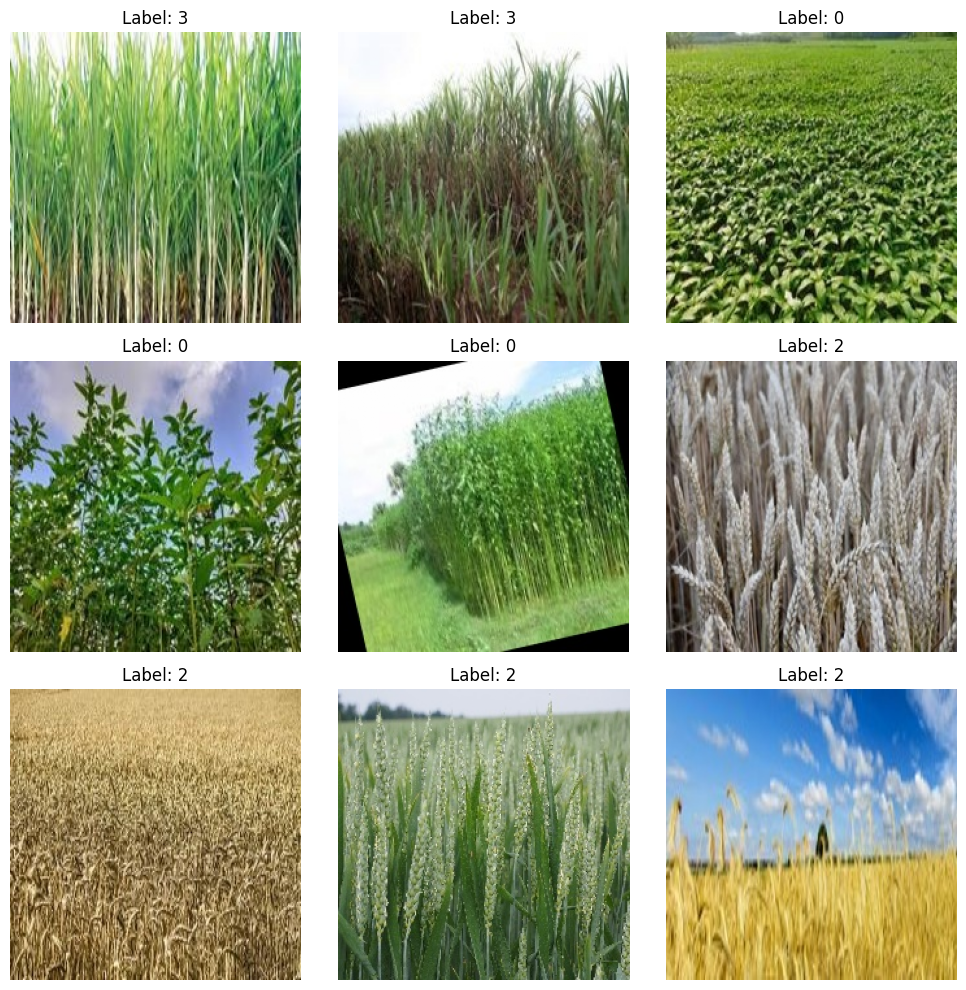

In [14]:

num_images = 9

grid_dim = int(np.sqrt(num_images))

fig, axes = plt.subplots(grid_dim, grid_dim, figsize=(10, 10))


axes = axes.flatten()

for i in range(num_images):
    img = images[i]  
    label = labels[i]  

   
   
    img = np.transpose(img.numpy(), (1, 2, 0)) # C, H, W -> H, W, C 

    axes[i].imshow(img)  
    axes[i].set_title(f'Label: {label}')  # Set title 
    axes[i].axis('off')  

# Adjust layout
plt.tight_layout()
plt.show()

# Build model

In [15]:
# Load pretrained VGG16 model
pre_model = models.vgg16(pretrained=True)


for param in pre_model.parameters():
    param.requires_grad = False


for param in pre_model.features[-6:].parameters():
    param.requires_grad = True
    

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 157MB/s]


In [16]:
classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, 5)  
)
pre_model.classifier = classifier

In [17]:
#define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Model = pre_model.to(device)

In [18]:
num_epochs = 4
lr = 0.0001



optimizer = Adam(Model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

print(f'Using device {device}')

Using device cuda


# Training model 

In [19]:
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    Model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for image, labels in train_loader:
        image = image.to(device)
        labels = labels.to(device)

        outputs = Model(image)
        loss = criterion(outputs, labels)

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}%")
    


    train_losses.append(epoch_loss)
    
    #-----------------------------------------------------------------------------------

    # Evaluate on the test set
    Model.eval()
    test_correct_predictions = 0
    test_total_samples = 0
    test_running_loss = 0.0

    with torch.no_grad():
        for image, labels in test_loader:
            image, labels = image.to(device), labels.to(device)

            outputs = Model(image)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            test_correct_predictions += (predicted == labels).sum().item()
            test_total_samples += labels.size(0)

    test_accuracy = test_correct_predictions / test_total_samples
    test_loss = test_running_loss / len(test_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")
    print()
    print("----------------------------------------------------------------------------")


    test_losses.append(test_loss)



Epoch 1/4, Train Loss: 0.7283, Train Accuracy: 73.72%
Epoch 1/4, Test Loss: 0.6438, Test Accuracy: 93.17%

----------------------------------------------------------------------------
Epoch 2/4, Train Loss: 0.1557, Train Accuracy: 99.53%
Epoch 2/4, Test Loss: 0.1965, Test Accuracy: 96.27%

----------------------------------------------------------------------------
Epoch 3/4, Train Loss: 0.0751, Train Accuracy: 100.00%
Epoch 3/4, Test Loss: 0.1240, Test Accuracy: 98.14%

----------------------------------------------------------------------------
Epoch 4/4, Train Loss: 0.0582, Train Accuracy: 100.00%
Epoch 4/4, Test Loss: 0.0931, Test Accuracy: 98.14%

----------------------------------------------------------------------------


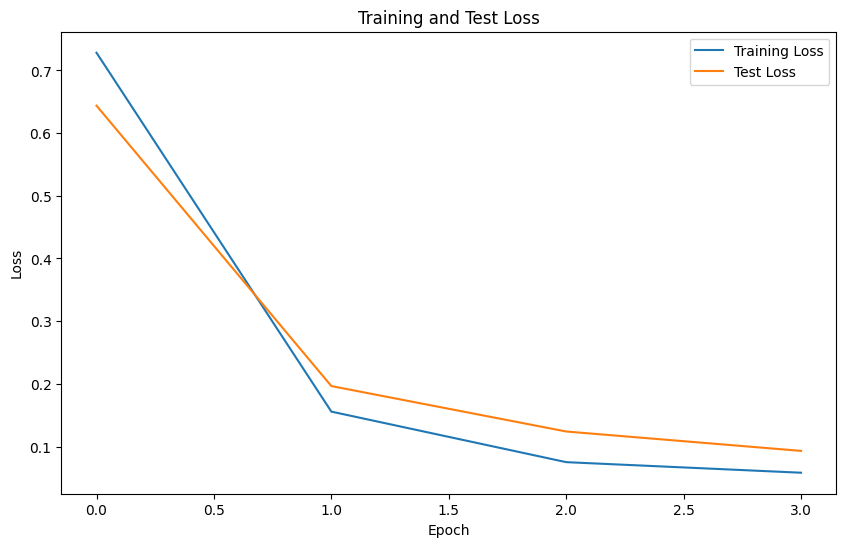

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Evaluate the model

In [21]:
test_correct_predictions = 0
test_total_samples = 0

Model.eval()
with torch.no_grad():
    for image, labels in test_loader:
        image, labels = image.to(device), labels.to(device)

        outputs = Model(image)
        loss = criterion(outputs, labels)   

        _, predicted = torch.max(outputs, 1)
        test_correct_predictions += (predicted == labels).sum().item()
        test_total_samples += labels.size(0)

test_accuracy = test_correct_predictions / test_total_samples
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


Test Accuracy: 98.14%


In [22]:
incorrect = []
correct = []

# Put the model in evaluation mode
pre_model.eval()

# Go through the test dataset
for i in range(len(test_dataset)):
    image, label = test_dataset[i]
    image = image.to(device).unsqueeze(0)  

    with torch.no_grad():
        prediction = pre_model(image)
        y_hat = torch.argmax(prediction, dim=1).item()

    if y_hat != label:
        incorrect.append([image, y_hat, label])
    else:
        correct.append([image, y_hat, label])
print(f'Number of all samples: {len(test_dataset)}')
print(f'Number of incorrect samples: {len(incorrect)}')
print(f'Number of correct samples: {len(correct)}')

Number of all samples: 161
Number of incorrect samples: 3
Number of correct samples: 158


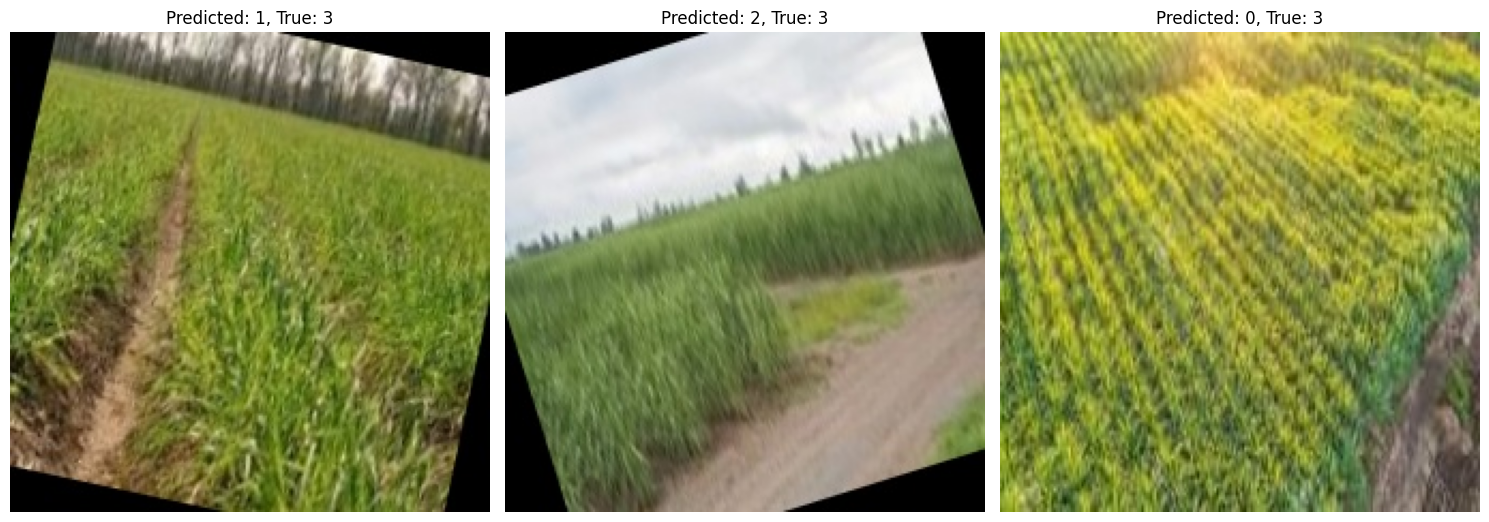

In [23]:
#Plot some incorrect samples
num_samples = min(len(incorrect), 5)  # Plot at most 5 incorrect samples
plt.figure(figsize=(15, 10))
for i in range(num_samples):
    image, y_hat, label = incorrect[i]
    image = image.squeeze(0).cpu().numpy()  
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(np.transpose(image, (1, 2, 0))) 
    plt.axis('off')
    plt.title(f'Predicted: {y_hat}, True: {label}')

plt.tight_layout()
plt.show()